In [4]:
"""
Test script for PGD attack on CLIP model
Compares original image vs perturbed image
"""
import sys

import torch
import torch.nn.functional as F
import torch.fft as fft
import torchvision.transforms as TF

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from src.pipe.pipe import MultimodalRetrievalPipeline
# from src.pipe.attacks import pgd_attack, fgsm_attack_clip


/hpc/group/csdept/aho13/labIR/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/group/csdept/aho13/labIR/venv/lib/python3.11/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
# Initialize the pipeline
print("Loading CLIP model...")
pipeline = MultimodalRetrievalPipeline()
pipeline.model.eval()
print("Model loaded successfully!")

Loading CLIP model...
Loading model on cpu...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully. Using dtype: torch.float16
Model loaded successfully!


In [6]:
# Load the test image
# image_path = '/work/aho13/MMEB-eval/VisualNews_i2t/washington_post_images_0444_223.jpg'
image_path= '/work/aho13/MMEB-eval/VisualNews_i2t/washington_post_images_0438_789.jpg'
img = Image.open(image_path).convert('RGB')

# Define a caption for the image
tgt_text = "A photo of an object"
# true_text = "A Maryland State Police cruiser sits at a blocked southbound entrance on the BaltimoreWashington Parkway that accesses Fort Meade."
true_text="Russia s Alexander Radulov hugs goalie Sergei Bobrovski right as Yevgeni Malkin skates next to them celebrating a 40 victory over Norway."
print(f"Image loaded: {image_path}")
print(f"Image size: {img.size}")
print(f"Test caption: {true_text}")

Image loaded: /work/aho13/MMEB-eval/VisualNews_i2t/washington_post_images_0438_789.jpg
Image size: (389, 256)
Test caption: Russia s Alexander Radulov hugs goalie Sergei Bobrovski right as Yevgeni Malkin skates next to them celebrating a 40 victory over Norway.


In [7]:
    # Preprocess the image and text for the model
    inputs = pipeline.processor(images=img, return_tensors="pt", padding=True)
    tgt_text_inputs = pipeline.processor(text=[tgt_text], return_tensors="pt", padding=True, truncation=True)
    true_text_inputs = pipeline.processor(text=[true_text], return_tensors="pt", padding=True, truncation=True)
    
    # Move to device
    pixel_values = inputs['pixel_values'].to(pipeline.model.device)
    tgt_text_ids = tgt_text_inputs['input_ids'].to(pipeline.model.device)
    true_text_ids = true_text_inputs['input_ids'].to(pipeline.model.device)
    tgt_text_attention_mask = tgt_text_inputs['attention_mask'].to(pipeline.model.device)
    
    true_text_attention_mask = true_text_inputs['attention_mask'].to(pipeline.model.device)
    
    print(f"Image tensor shape: {pixel_values.shape}")
    print(f"Text input shape: {tgt_text_ids.shape}")
    print(f"Text attention mask shape: {tgt_text_attention_mask.shape}")


Image tensor shape: torch.Size([1, 3, 224, 224])
Text input shape: torch.Size([1, 7])
Text attention mask shape: torch.Size([1, 7])


In [8]:
# Get text embedding for the attack
with torch.no_grad():
    tgt_text_embeds = pipeline.model.get_text_features(
        input_ids=tgt_text_ids,
        attention_mask=tgt_text_attention_mask
    )
    tgt_text_embeds = tgt_text_embeds / tgt_text_embeds.norm(dim=-1, keepdim=True)

    true_text_embeds = pipeline.model.get_text_features(
        input_ids=true_text_ids,
        attention_mask=true_text_attention_mask
    )
    true_text_embeds = true_text_embeds / true_text_embeds.norm(dim=-1, keepdim=True)
    
    
    # Get original image embedding
    original_img_embeds = pipeline.model.get_image_features(pixel_values=pixel_values)
    original_img_embeds = original_img_embeds / original_img_embeds.norm(dim=-1, keepdim=True)
    
    # Calculate original similarity
    original_similarity = torch.cosine_similarity(original_img_embeds, true_text_embeds).item()

print(f"Original similarity: {original_similarity:.4f}")

Original similarity: 0.3360


In [6]:
def pgd_linf_step(delta, grad, eps, alpha):
    """
    Performs one PGD step under the L∞ constraint.

    delta: current perturbation (x_adv - x)
    grad: gradient w.r.t. x_adv
    eps: L∞ max magnitude
    alpha: step size
    """
    # Sign step
    delta = delta + alpha * grad.sign()

    # Project to L∞ ball
    delta = delta.clamp(-eps, eps)

    return delta

def pgd_l2_step(delta, grad, eps, alpha, eps_tol=1e-12):
    """
    Performs one PGD step under the L2 constraint.
    """

    # Compute L2 norm of gradient
    grad_norm = torch.norm(grad.view(grad.size(0), -1), dim=1)
    grad_norm = grad_norm.view(-1, 1, 1, 1)

    # Avoid divide-by-zero
    grad_normalized = grad / (grad_norm + eps_tol)

    # Step
    delta = delta + alpha * grad_normalized

    # Project back to L2 ball
    delta_flat = delta.view(delta.size(0), -1)
    delta_norm = torch.norm(delta_flat, p=2, dim=1).view(-1, 1, 1, 1)
    scale = torch.clamp(eps / (delta_norm + eps_tol), max=1.0)

    delta = delta * scale

    return delta

def pgd_l1_step(delta, grad, eps, alpha, sparsity=None):
    """
    Performs one PGD step under the L1 constraint.

    sparsity: optional float in [0,1]
              proportion of pixels to KEEP (1 - sparsity removed)
    """
    B, C, H, W = grad.shape
    flat = grad.view(B, -1)
    abs_flat = flat.abs()

    # Determine how many pixels to keep
    if sparsity is None:
        k = 1  # classic L1 PGD = keep only the max element
    else:
        total = flat.size(1)
        k = max(1, int((1 - sparsity) * total))

    # Top-k mask
    vals, idx = abs_flat.topk(k, dim=1)
    mask = torch.zeros_like(flat)
    mask.scatter_(1, idx, 1.0)

    # Apply mask
    grad_sparse = flat.sign() * mask
    grad_sparse = grad_sparse.view_as(grad)

    # Normalize to unit L1
    l1_norm = grad_sparse.abs().sum(dim=(1,2,3), keepdim=True)
    grad_normalized = grad_sparse / (l1_norm + 1e-12)

    # Step
    delta = delta + alpha * grad_normalized

    # Project delta back into L1 ball
    delta_flat = delta.view(B, -1)
    l1_norm = delta_flat.abs().sum(dim=1, keepdim=True)

    factor = torch.clamp(eps / (l1_norm + 1e-12), max=1.0)
    delta_flat = delta_flat * factor
    delta = delta_flat.view_as(delta)

    return delta


In [9]:
# Total Variation Norm
def tv_norm(x):
    
    dh = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]).mean()
    dw = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]).mean()
    return dh + dw
def pgd_attack(pipeline, x, norm='linf', text_emb=None, eps = 1/225, alpha = None, steps=10,rand_init=True):
    x_adv = x.clone().detach().requires_grad_(True).to(pipeline.model.device)

    if alpha is None:
        alpha = eps / steps
    # default generic text embedding (take away semantic_similarity)
    alpha = eps/steps
    x = x.detach().to(pipeline.model.device)
    
    if text_emb is None:
        # text_emb 
        tgt_text = "a photo of an object"
        tgt_text_inputs = pipeline.processor(
            text=[tgt_text], 
            return_tensors="pt", 
            padding=True, 
            truncation=True
        )
        # Move text inputs to device
        tgt_text_inputs = {k: v.to(pipeline.model.device) for k, v in tgt_text_inputs.items()}
        text_emb = pipeline.model.get_text_features(**tgt_text_inputs)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        
    text_emb = text_emb.detach().to(pipeline.model.device)
    loss=0
    
    # initalize delta properly inside L infinity "ball"
    if rand_init:
        delta = torch.empty_like(x).uniform_(-eps,eps)
    else:
        delta = torch.zeros_like(x)
    delta = delta.clamp(-eps,eps).detach().requires_grad_(True)

    for i in (range(steps)):
        # Forward pass through model
        x_adv = (x + delta).clamp(0,1)
        
        img_emb = pipeline.model.get_image_features(x_adv)
        
        # Calculate loss to minimize cosine similarity to break alignment
        loss = F.cosine_similarity(img_emb, text_emb).mean()

        # Compute gradients
        pipeline.model.zero_grad()
        loss.backward()  
        grad = x_adv.grad

        if norm == "inf":
            delta = pgd_linf_step(delta, grad, eps, alpha)
    
        elif norm == "l2":
            delta = pgd_l2_step(delta, grad, eps, alpha)
    
        elif norm == "l1":
            delta = pgd_l1_step(delta, grad, eps, alpha, sparsity=0.95)

    return x_adv.to("cpu"), loss

In [10]:
# This attack is based on the FGSM attack on CLIP to reduce image-text similarity.
def fgsm_attack(image, pipeline, epsilon=0.01, target_text=None):
    """
    FGSM attack on CLIP to reduce image-text similarity.
    
    Args:
        image: PIL Image
        pipeline: MultimodalRetrievalPipeline with CLIP model
        epsilon: Perturbation magnitude (default 0.03)
        target_text: Optional specific text to attack against. If None, uses generic text.
    
    Returns:
        Perturbed PIL Image
    """
    # Use a generic text if none provided
    # This genereci text is aimed to reduce image-text similarity
    if target_text is None:
        target_text = "A photo of an object"
    
    # Convert image to tensor with CLIP preprocessing
    img_rgb = image.convert("RGB")
    transform = TF.Compose([
        TF.Resize((224, 224)),
        TF.ToTensor(),
        TF.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], 
                     std=[0.26862954, 0.26130258, 0.27577711])
    ])
    
    img_tensor = transform(img_rgb).unsqueeze(0).to(pipeline.model.device)
    img_tensor.requires_grad = True
    
    # Encode text (target to reduce similarity with)
    text_inputs = pipeline.processor(text=[target_text], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(pipeline.model.device) for k, v in text_inputs.items()}
    
    with torch.enable_grad():
        # Get embeddings
        text_embeds = pipeline.model.get_text_features(**text_inputs)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        
        image_embeds = pipeline.model.get_image_features(pixel_values=img_tensor)
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        
        # Loss: maximize distance (minimize similarity)
        # We want to REDUCE relevance, so we minimize the negative similarity
        similarity = F.cosine_similarity(image_embeds, text_embeds)
        loss = similarity.mean()  # We'll add gradient to reduce this
        
        # Backprop
        pipeline.model.zero_grad()
        loss.backward()
        
        # FGSM: perturb in direction that INCREASES loss (reduces similarity)
        # Since we want to reduce similarity, we add epsilon * sign(gradient)
        sign_grad = img_tensor.grad.sign()
        perturbed_tensor = img_tensor + epsilon * sign_grad
        
        # Denormalize back to [0, 1] range
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1).to(pipeline.model.device)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1).to(pipeline.model.device)
        
        perturbed_tensor = perturbed_tensor * std + mean
        perturbed_tensor = torch.clamp(perturbed_tensor, 0, 1)
    
    # # Convert back to PIL Image
    # perturbed_np = perturbed_tensor.squeeze(0).detach().cpu().numpy()
    # perturbed_np = (perturbed_np.transpose(1, 2, 0) * 255).astype(np.uint8)
    # perturbed_image = Image.fromarray(perturbed_np)
    
    # # Resize back to original size if needed
    # if perturbed_image.size != image.size:
    #     perturbed_image = perturbed_image.resize(image.size, Image.LANCZOS)
    
    return perturbed_tensor
        

In [11]:
# apply fgsm attack
fgsm_pixels = fgsm_attack(img, pipeline)

In [12]:
# Apply PGD attack
eps = 0.1/255
# alpha = 0.0/255
print("Applying PGD attack...")
# norms = ['linf','l2','l1']
# for norm in norms:
pgd_pixels, final_loss = pgd_attack(
    pipeline=pipeline,
    x=pixel_values,
    norm='linf',
    text_emb=tgt_text_embeds,
    eps=eps,      # epsilon: maximum perturbation
    alpha=None,    # step size
    steps=10        # number of iterations
)
# perturbed_pixels = tv_clean(perturbed_pixels)

print(f"Attack complete! Final loss: {final_loss:.4f}")

Applying PGD attack...


/hpc/group/csdept/aho13/tmp/ipykernel_3998170/2231050754.py:52: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad = x_adv.grad


Attack complete! Final loss: 0.2130


In [59]:
# Calculate perturbed image similarity
def calculate_similarity(pipeline, perturbed_pixels, perturb_type):
    with torch.no_grad():
        perturbed_img_embeds = pipeline.model.get_image_features(pixel_values=perturbed_pixels.to("cuda"))
        perturbed_img_embeds = perturbed_img_embeds / perturbed_img_embeds.norm(dim=-1, keepdim=True)
        perturbed_similarity = torch.cosine_similarity(perturbed_img_embeds, true_text_embeds).item()
        tgt_similarity = torch.cosine_similarity(perturbed_img_embeds, tgt_text_embeds).item()
    
    reduction = ((original_similarity - perturbed_similarity) / original_similarity) * 100
    
    print(f"{perturb_type} perturbed image similarity with true label: {perturbed_similarity:.4f}")
    print(f"  Target similarity: {tgt_similarity:.4f}")
    print(f"  Similarity reduction: {reduction:.1f}%")
    print(f"  Absolute change: {original_similarity - perturbed_similarity:.4f}")
    return perturbed_similarity, tgt_similarity, reduction
    
pgd_sim, pgd_tgt_sim, pgd_red = calculate_similarity(pipeline, pgd_pixels, "PGD")
fgsm_sim, fgsm_tgt_sim, fgsm_red = calculate_similarity(pipeline, fgsm_pixels, "fgsm")

PGD perturbed image similarity with true label: 0.2487
  Target similarity: 0.2130
  Similarity reduction: 26.0%
  Absolute change: 0.0872
fgsm perturbed image similarity with true label: 0.3218
  Target similarity: 0.1703
  Similarity reduction: 4.2%
  Absolute change: 0.0141


In [60]:
# Convert tensors back to images for visualization
def tensor_to_image(tensor, denormalize=True):
    """Convert a normalized tensor to PIL Image"""
    # Move to CPU and convert to numpy
    img_array = tensor.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
    
    if denormalize:
        # CLIP uses ImageNet normalization
        mean = np.array([0.48145466, 0.4578275, 0.40821073])
        std = np.array([0.26862954, 0.26130258, 0.27577711])
        
        # Denormalize: x = x * std + mean
        img_array = img_array * std + mean
    
    # Clip values to [0, 1] range
    img_array = np.clip(img_array, 0, 1)
    # Convert to uint8
    img_array = (img_array * 255).astype(np.uint8)
    return Image.fromarray(img_array)

original_img_display = tensor_to_image(pixel_values, denormalize=True)
pgd_img_display = tensor_to_image(pgd_pixels, denormalize=True)
fgsm_img_display = tensor_to_image(fgsm_pixels, denormalize=True)


print("Images converted for display")

Images converted for display


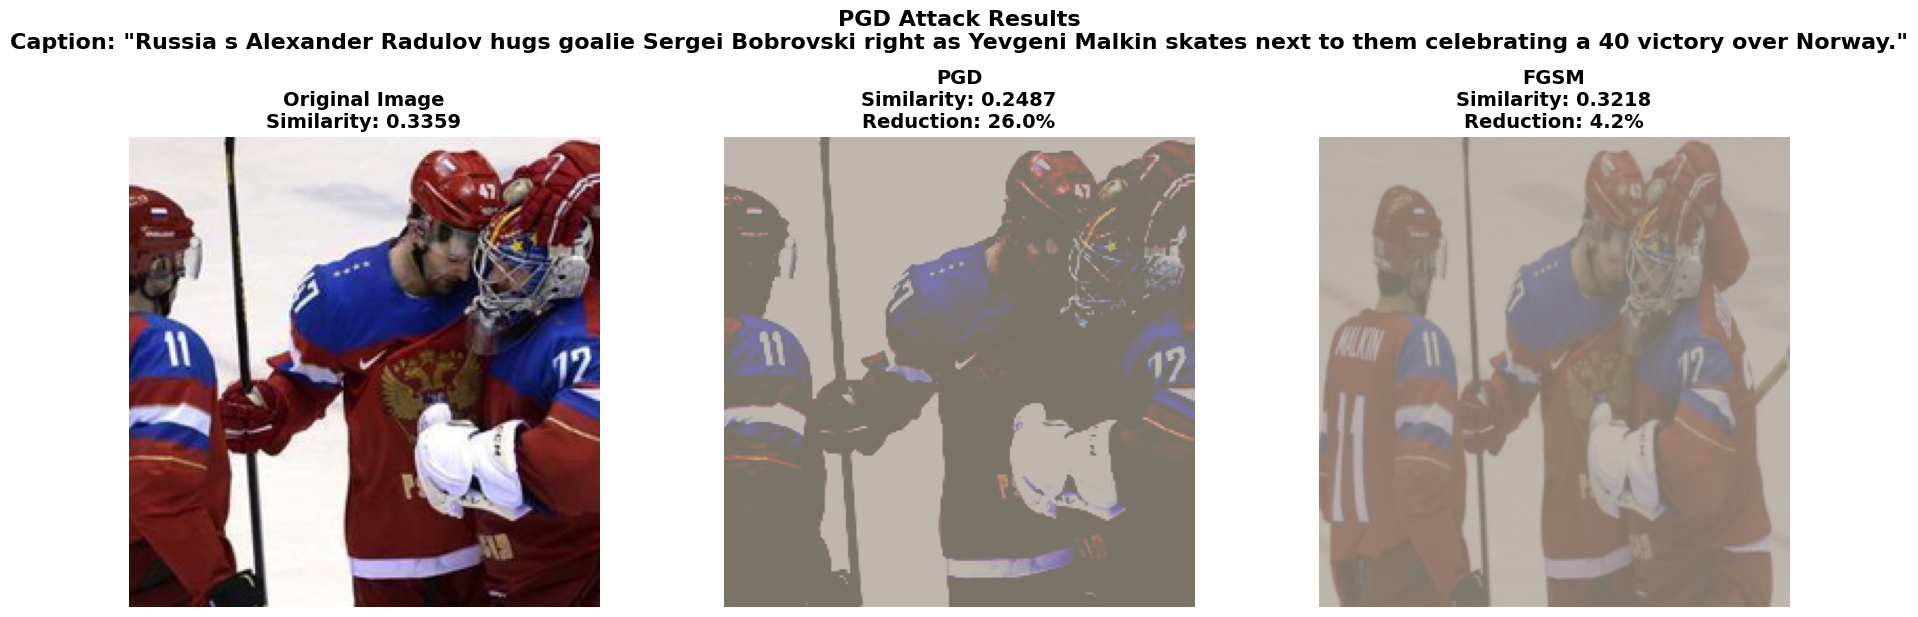


PGD and FGSM Attack DEMOs Complete!


In [61]:
# Visualize original vs perturbed image
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(original_img_display)
axes[0].set_title(f'Original Image\nSimilarity: {original_similarity:.4f}', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Perturbed image
axes[1].imshow(perturbed_img_display)
axes[1].set_title(f'PGD\nSimilarity: {pgd_sim:.4f}\nReduction: {pgd_red:.1f}%', 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

# Difference (amplified for visibility)
# diff = np.abs(np.array(original_img_display).astype(float) - np.array(perturbed_img_display).astype(float))
# diff_amplified = np.clip(diff , 0, 255).astype(np.uint8)
axes[2].imshow(fgsm_img_display)
axes[2].set_title(f'FGSM\nSimilarity: {fgsm_sim:.4f}\nReduction: {fgsm_red:.1f}%', fontsize=14, fontweight='bold')
axes[2].axis('off')


plt.suptitle(f'PGD Attack Results\nCaption: "{true_text}"', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PGD and FGSM Attack DEMOs Complete!")
print("="*60)